In [1]:
from pathlib import Path

from matplotlib.cm import get_cmap
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [2]:
# define constants

DATA = Path.home() / 'devel/motiondetection'
DATA_ROOT = DATA / 'data'

In [3]:
print(DATA_ROOT)

/home/michele/devel/motiondetection/data


### Load data

**Data description**
- Column 1: Time in seconds
- Column 2: Acceleration reading in G for frontal axis
- Column 3: Acceleration reading in G for vertical axis
- Column 4: Acceleration reading in G for lateral axis
- Column 5: Id of antenna reading sensor
- Column 6: Received signal strength indicator (RSSI)
- Column 7: Phase
- Column 8: Frequency
- Column 9: Label of activity, 1: sit on bed, 2: sit on chair, 3: lying, 4: ambulating

In [4]:
dfs = []
activities = ['bed', 'chair', 'lying', 'ambulating']
default_names = ['time', 'front', 'vertical', 'lateral', 'sensor_id', 'rssi', 'phase', 'frequency', 'activity']
for data_file in DATA_ROOT.rglob('d[12]p??[FM]'):
    df = pd.read_csv(data_file, names=default_names)
    df['activity_label'] = df['activity'].apply(lambda i: activities[i - 1])
    df['gender_label'] = str(data_file)[-1]
    df['participant'] = data_file.name
    dfs.append(df)

activity_df = pd.concat(dfs, axis='index')
activity_df.to_csv('activity_df.csv')

In [5]:
activity_df.head()

,time,front,vertical,lateral,sensor_id,rssi,phase,frequency,activity,activity_label,gender_label,participant
0,0.000,0.037521,0.91636,-0.367180,2,-47.0,4.401000,923.25,4,ambulating,F,d1p26F
1,0.025,0.037521,0.91636,-0.367180,2,-47.0,4.158600,923.25,4,ambulating,F,d1p26F
2,0.075,0.037521,0.91636,-0.367180,2,-48.0,0.072097,923.25,4,ambulating,F,d1p26F
3,0.100,0.236850,1.05420,0.168760,2,-48.0,1.998800,923.25,4,ambulating,F,d1p26F
4,0.500,0.049247,1.00820,0.088944,2,-58.0,1.572300,921.25,4,ambulating,F,d1p26F


In [6]:
len(activity_df.participant.unique())

87

In [7]:
participant = 'd2p24F'
df = activity_df[activity_df['participant'] == participant]
df.head()

,time,front,vertical,lateral,sensor_id,rssi,phase,frequency,activity,activity_label,gender_label,participant
0,0.00,0.025796,1.00820,0.077541,3,-60.0,2.5142,922.25,4,ambulating,F,d2p24F
1,1.50,0.213400,0.96229,-0.070699,2,-59.0,3.8442,924.75,4,ambulating,F,d2p24F
2,2.25,0.213400,0.96229,-0.070699,3,-66.5,1.2287,920.75,4,ambulating,F,d2p24F
3,2.75,0.213400,0.96229,-0.070699,2,-59.5,4.7185,923.25,4,ambulating,F,d2p24F
4,3.75,0.143050,0.84746,-0.002281,2,-65.0,5.5423,924.75,4,ambulating,F,d2p24F


### Get transitions

In [6]:
# find where the activities change 
transitions = np.where(df['activity'].values[:-1] != df['activity'].values[1:])[0]
start = 0
bounds = []
for end in transitions:
    bounds.append({
        'activity': df['activity'][start], 
        'activity_label': df['activity_label'][start], 
        'start_index': start, 
        'end_index': end,
        'start_time': df['time'][start],
        'end_time': df['time'][end]
    })
    start = end + 1
bound_df = pd.DataFrame(bounds)

In [7]:
bound_df.head()

,activity,activity_label,start_index,end_index,start_time,end_time
0,4,ambulating,0,5,0.00,4.00
1,2,chair,6,71,5.75,102.00
2,4,ambulating,72,75,105.75,108.25
3,1,bed,76,212,109.25,168.00
4,3,lying,213,1330,168.25,391.25


In [8]:
bound_df.shape

(9, 6)

### Plot

Plot from 0 - ~200s

In [14]:
min_t = 0
max_t = 200
bound_df = bound_df[bound_df['start_time'] < max_t]
bound_df

,activity,activity_label,start_index,end_index,start_time,end_time
0,4,ambulating,0,4,0.00,3.75
1,1,bed,5,18,5.00,11.75
2,3,lying,19,45,12.00,143.75
3,1,bed,46,57,144.50,157.25
4,4,ambulating,58,68,161.25,168.25
5,2,chair,69,73,175.50,201.75


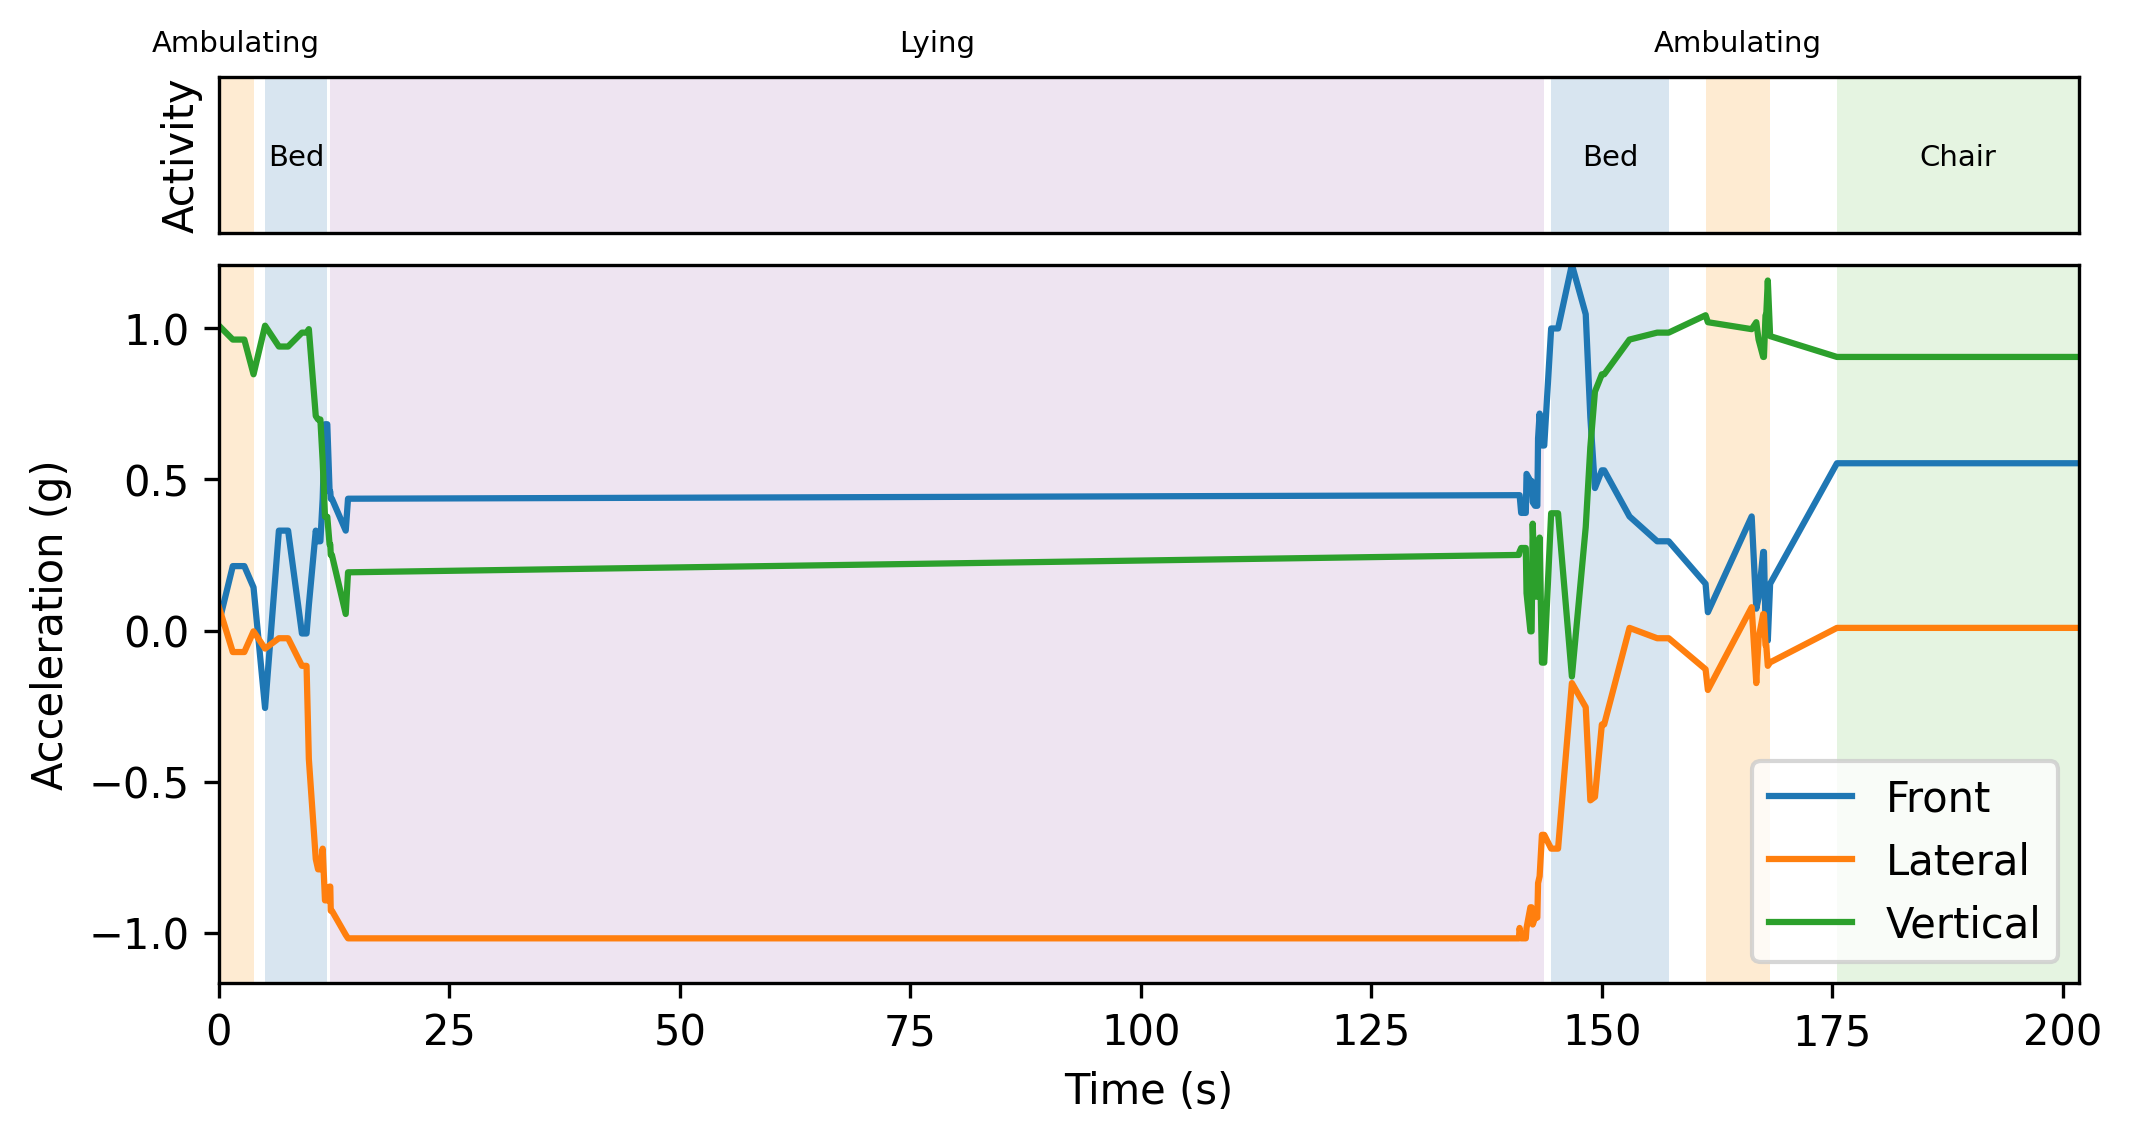

In [15]:
colors = get_cmap('Pastel1').colors

# Make sure we get the whole of the last activity
xlim = (bound_df.iloc[0]['start_time'], bound_df.iloc[-1]['end_time'])

fig = plt.figure(figsize=(8,4), dpi=300)
gs = fig.add_gridspec(5, 1)
ax_top = fig.add_subplot(gs[0, :])
ax = fig.add_subplot(gs[1:, :])

t = df['time']
for column in ['front', 'lateral', 'vertical']:
    ax.plot(t, df[column], label=column.capitalize())

ax.set_ylabel('Acceleration (g)')
ax.set_xlabel('Time (s)')
ax.margins(0)
ax.legend(loc='lower right')

ax_top.set_xlim(ax.get_xlim())
ax_top.set_ylim((0, 1))
ax_top.set_xticks([])
ax_top.set_yticks([])
ax_top.set_ylabel('Activity')
ymin, ymax = ax.get_ylim()
height = ymax - ymin


for i, bound in bound_df.iterrows():
    x = bound['start_time']
    y = ymin
    width = bound['end_time'] - bound['start_time']
    rect = mpatches.Rectangle(
        [x, y], width, height, alpha=0.5, color=colors[bound['activity']], linewidth=0)

    ax.add_patch(rect)
    
    rect = mpatches.Rectangle(
        [x, 0], width, 1, alpha=0.5, color=colors[bound['activity']], linewidth=0)
    ax_top.add_patch(rect)
    
    text_x = x + width / 2
    # FIXME: crappy vertical position
    text_y = 1.125 - (i % 2) / 1.375
    ax_top.text(
        text_x, 
        text_y, 
        bound['activity_label'].capitalize(), 
        fontsize=7, 
        ha='center', 
        va='bottom')

ax.set_xlim(xlim)
ax_top.set_xlim(xlim)

fig.savefig('acceleration.jpeg')